# Anomaly Detection: Knowledge Distillation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import sys

from tqdm.notebook import trange
from sklearn.metrics import roc_curve, auc

## Training the Oracle: LeNet5 Classifier

In [2]:
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])),
  batch_size=256, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])),
  batch_size=1, shuffle=False)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [3]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

oracle = LeNet5().to(0)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(oracle.parameters(), lr=0.1)
epochs = 40

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':1.5f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{avg' + self.fmt + '} ({name})'
        return fmtstr.format(**self.__dict__)

In [6]:
acc, loss = AverageMeter('Accuracy'), AverageMeter('Loss')

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    oracle.train()
    
    # Reset our meters
    acc.reset()
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, targets in train_dataloader:
        
        inputs, targets = inputs.to(0), targets.to(0)
        
        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        outputs = oracle(inputs)

        # Compute the loss and accuracy
        loss_batch = criterion(outputs, targets)
        
        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer.step()      

        preds = torch.argmax(outputs, dim=-1)
        accuracy = (targets == preds).sum() / len(targets)
        acc.update(accuracy.data)
        loss.update(loss_batch.data)

        # Show the current results
        tr.set_description('Epoch {}, {}, {}'.format(epoch+1, loss, acc))
        tr.update(1)

In [7]:
# Get the anomaly scores

losses = []

oracle.eval()
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(0), targets.to(0)
    outputs = oracle(inputs)
    loss = criterion(outputs, targets)
    losses.append(loss.item())

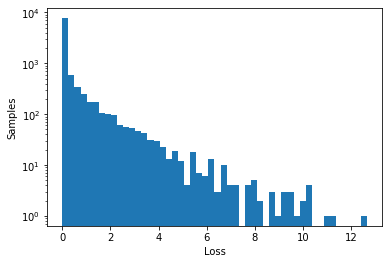

In [8]:
# Check the loss distibution

plt.hist(losses, bins=50)
plt.xlabel("Loss")
plt.ylabel("Samples")
plt.semilogy();

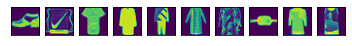

In [9]:
# Plot the most anomlaous samples

cut = sorted(losses)[-10]
figure1, axis1 = plt.subplots(1, 10)
i = 0
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(0), targets.to(0)
    outputs = oracle(inputs)
    loss = criterion(outputs, targets)
    if loss >= cut:
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(inputs.view(28, 28).detach().cpu().numpy())
        i += 1

## Teacher Network: Autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 4, stride=2,padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
ae = Autoencoder().to(0)

In [12]:
criterion_ae = nn.BCELoss()
optimizer_ae = optim.Adam(ae.parameters())

In [13]:
loss = AverageMeter('Loss')

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    ae.train()
    
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, _ in train_dataloader:
        
        inputs = inputs.to(0)
        
        # Remove previous gradients
        optimizer_ae.zero_grad()
        
        # Feed forward the input
        outputs = ae(inputs)

        # Compute the loss and accuracy
        loss_batch = criterion_ae(outputs, inputs)
        
        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer_ae.step()

        # Show the current results
        loss.update(loss_batch.data)
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

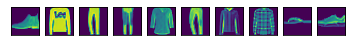

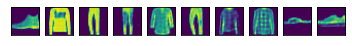

In [14]:
# Plot some reconstruction examples

figure1, axis1 = plt.subplots(1, 10)
figure2, axis2 = plt.subplots(1, 10)
i = 0
for i, (inputs, _) in enumerate(test_dataloader):
    inputs = inputs.to(0)
    outputs = ae(inputs)
    
    axis1[i].get_xaxis().set_visible(False)
    axis1[i].get_yaxis().set_visible(False)
    axis1[i].imshow(inputs.view(28, 28).detach().cpu().numpy())
    
    axis2[i].get_xaxis().set_visible(False)
    axis2[i].get_yaxis().set_visible(False)
    axis2[i].imshow(outputs.view(28, 28).detach().cpu().numpy())

    if i == 9:
        break

In [15]:
# Get the teacher scores

ae.eval()

scores = []
for inputs, _ in test_dataloader:
    inputs = inputs.to(0)
    outputs = ae(inputs)
    loss = criterion_ae(outputs, inputs)
    scores.append(loss.item())

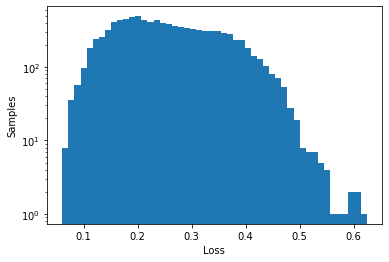

In [16]:
# Check the score distibution

plt.hist(scores, bins=50)
plt.xlabel("Loss")
plt.ylabel("Samples")
plt.semilogy();

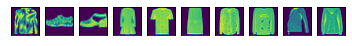

In [17]:
# Plot the most anomlaous samples according to the Teacher

cut = sorted(scores)[-10]
figure1, axis1 = plt.subplots(1, 10)
i = 0
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(0), targets.to(0)
    outputs = oracle(inputs)
    loss = criterion(outputs, targets)
    if loss >= cut:
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(inputs.view(28, 28).detach().cpu().numpy())
        i += 1
    if i == 10: 
        break

In [18]:
from sklearn.metrics import roc_curve, auc

ANOMALY_THRESHOLD = 3

fpr, tpr, _ = roc_curve(0 + (np.array(losses) > ANOMALY_THRESHOLD), scores)
auc(fpr, tpr)

0.5653979232171237

## Student: Shallow Network

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Shallow(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

student = Shallow().to(0)

In [20]:
criterion_student = nn.MSELoss()
criterion_teacher = nn.BCELoss(reduction='none')
optimizer_student = optim.Adam(student.parameters(), lr=0.01)

In [21]:
loss = AverageMeter('Loss')

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    student.train()
    
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, _ in train_dataloader:
        
        inputs = inputs.to(0)
        
        # Remove previous gradients
        optimizer_student.zero_grad()
        
        # Feed forward the input
        outputs = student(inputs)
        
        outputs_teacher = ae(inputs)
        loss_teacher = criterion_teacher(outputs_teacher, inputs).mean(-1).mean(-1) * 100

        # Compute the loss and accuracy
        loss_batch = criterion_student(outputs, loss_teacher)
        
        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer_student.step()

        # Show the current results
        loss.update(loss_batch.data)
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

In [22]:
# Get the students scores

student.eval()

scores_student = []
for inputs, _ in test_dataloader:
    inputs = inputs.to(0)
    outputs = student(inputs)
    scores_student.append(outputs.item())

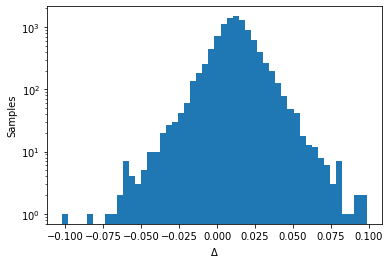

In [23]:
# Check the delta distibution

plt.hist(np.array(scores)-np.array(scores_student)/100, bins=50)
plt.xlabel("$\Delta$")
plt.ylabel("Samples")
plt.semilogy();

In [24]:
teacher_aucs = []
student_aucs = []
cuts = []

for ANOMALY_THRESHOLD in sorted(np.array(losses))[::10]:
    fpr, tpr, _ = roc_curve(0 + (np.array(losses) > ANOMALY_THRESHOLD), scores)
    teacher_aucs.append(auc(fpr, tpr))

    fpr, tpr, _ = roc_curve(0 + (np.array(losses) > ANOMALY_THRESHOLD), scores_student)
    student_aucs.append(auc(fpr, tpr))
    
    cuts.append(ANOMALY_THRESHOLD)

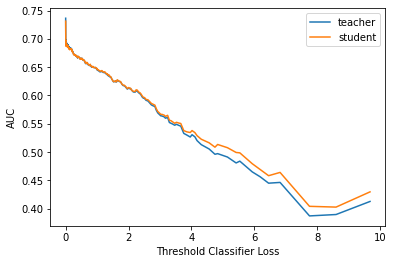

In [25]:
plt.plot(cuts, teacher_aucs, label='teacher')
plt.plot(cuts, student_aucs, label='student')
plt.ylabel("AUC")
plt.xlabel("Threshold Classifier Loss")
plt.legend()
plt.show();